## Analysis notebook for PRIDICT subscreen

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir

In [2]:
lsize=13
titlesize=14
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [3]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\03_Subscreen_SelfTarget\\NGS\\20220224_NovaSeq\\'

def list_files1(directory):
    return [f for f in listdir(directory) if '_analysis' in f]

sampledf = pd.DataFrame(columns=['filename','Nr','Cell_line','Editor','Replicate'])
filelist = list_files1(path+"Analysis\\")
sampledf['filename'] = filelist
sampledf['Nr'] = sampledf['filename'].apply(lambda x: x[9:11])
sampledf['Cell_line'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[0])
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[1])
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[2])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'Control' in x else False)
sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)

In [4]:
templatepath='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\03_Subscreen_SelfTarget\\NGS\\20220224_NovaSeq\\'
templatedf = pd.read_csv(templatepath+'20220227_subscreen_templatedf_extended.csv')
templatedf = templatedf.set_index('Unnamed: 0')

### Calculate sequence characteristics

In [5]:
# add values of control replicates to dataframe
for index, row in sampledf[sampledf['Editor'] == 'Control'].iterrows():
        dataframe = pd.read_csv(path+"Analysis\\"+row.filename)
        dataframename = row.Cell_line+"_"+row.Editor+"_"+row.Replicate
        templatedf[dataframename+'_totalreads'] = dataframe['totalreads']
        templatedf[dataframename+'_percentageedited'] = dataframe['percentageedited']
        templatedf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        templatedf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        templatedf[dataframename+'_editedcount'] = dataframe['editedcount']
        templatedf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        templatedf[dataframename+'_indelcount'] = dataframe['indelcount']
        templatedf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
        templatedf[dataframename+'_beforeflapindelcount'] = dataframe['beforeflapindelcount']
        templatedf[dataframename+'_percentagenickindel'] = templatedf.apply(lambda x: x[dataframename+'_nickindelcount']/x[dataframename+'_totalreads'],axis=1)
        templatedf[dataframename+'_percentagebeforeflapindel'] = templatedf.apply(lambda x: x[dataframename+'_beforeflapindelcount']/x[dataframename+'_totalreads'],axis=1)

In [6]:
startposition = 10 
protolength = 19

protospacerlocation = [startposition,startposition+protolength] #position within wide_target_sequnence; where it starts and where it ends

for index,row in templatedf.iterrows():
    valuerv = str(Seq(str(row.value)).reverse_complement())
    editedvaluerv = str(Seq(str(row.editedvalue)).reverse_complement())
    initial_seq = valuerv[6:105]
    mutated_seq = editedvaluerv[6:105]
    PBSlocation = [startposition+protolength-3-row.PBSlength,startposition+protolength-3]

    if row.Correction_Type == 'Replacement':
        editposition = startposition+protolength-3+row.Editing_Position
        RTlocation_mut = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength)]
        RTlocation_wt = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength)]

    elif row.Correction_Type == 'Insertion':
        editposition = startposition+protolength-3+row.Editing_Position
        RTlocation_mut = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength)]
        RTlocation_wt = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength-row.Correction_Length)]
    elif row.Correction_Type == 'Deletion':
        editposition = startposition+protolength-3+row.Editing_Position
        RTlocation_mut = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength)]
        RTlocation_wt = [startposition+protolength-3,int(startposition+protolength-3+row.RTlength+row.Correction_Length)]
 
    templatedf.at[index,'protospacerlocation_only_initial'] = str(protospacerlocation)
    templatedf.at[index,'PBSlocation'] = str(PBSlocation)
    templatedf.at[index,'RT_initial_location'] = str(RTlocation_wt)
    templatedf.at[index,'RT_mutated_location'] = str(RTlocation_mut)
    templatedf.at[index,'wide_initial_target'] = initial_seq
    templatedf.at[index,'wide_mutated_target'] = mutated_seq
    templatedf.at[index,'Editing_Position_Deep'] = editposition

In [7]:
polytlist=[]
polyglist=[]
polyalist=[]
polyclist=[]
for index, row in templatedf.iterrows():
    polytvalue = 0
    polygvalue = 0
    polyavalue = 0
    polycvalue = 0
    protospacer = row['value'][19:39]
    extension = row['RTT']+row['PBS']

    for x in range(1,20):
        if ('T'*x in protospacer) or ('T'*x in extension):
            polytvalue = x
        if ('G'*x in protospacer) or ('G'*x in extension):
            polygvalue = x
        if ('A'*x in protospacer) or ('A'*x in extension):
            polyavalue = x
        if ('C'*x in protospacer) or ('C'*x in extension):
            polycvalue = x
    polytlist.append(polytvalue)
    polyglist.append(polygvalue)
    polyalist.append(polyavalue)
    polyclist.append(polycvalue)
templatedf['polytvalues']=polytlist
templatedf['polygvalues']=polyglist
templatedf['polyavalues']=polyalist
templatedf['polycvalues']=polyclist

In [8]:
templatedf['Extension_seq'] = templatedf.apply(lambda x: x['RTT']+x['PBS'], axis=1)
templatedf['RToverhang_seq'] = templatedf.apply(lambda x: x['RTT'][:x['RToverhanglength']], axis=1)

In [9]:
templatedf['Proto_GC_content'] = [GC(x[19:19+20]) for x in templatedf['value'].tolist()]
templatedf['Extension_GC_content'] = templatedf.apply(lambda x: GC(x['Extension_seq']), axis=1)
templatedf['RT_GC_content'] = templatedf.apply(lambda x: GC(x['RTT']), axis=1)
templatedf['PBS_GC_content'] = templatedf.apply(lambda x: GC(x['PBS']), axis=1)
templatedf['original_GC_content'] = templatedf.apply(lambda x: GC(x['AlternateAllele']), axis=1)
templatedf['edited_GC_content'] = templatedf.apply(lambda x: GC(x['ReferenceAllele']), axis=1)

In [10]:
templatedf['Proto_GC_count'] = templatedf.apply(lambda x: x['value'][19:19+20].count('G')+x['value'][19:19+20].count('C'), axis=1)
templatedf['Extension_GC_count'] = templatedf.apply(lambda x: x['Extension_seq'].count('G')+x['Extension_seq'].count('C'), axis=1)
templatedf['RT_GC_count'] = templatedf.apply(lambda x: x['RTT'].count('G')+x['RTT'].count('C'), axis=1)
templatedf['PBS_GC_count'] = templatedf.apply(lambda x: x['PBS'].count('G')+x['PBS'].count('C'), axis=1)
templatedf['original_GC_count'] = templatedf.apply(lambda x: x['AlternateAllele'].count('G')+x['AlternateAllele'].count('C'), axis=1)
templatedf['edited_GC_count'] = templatedf.apply(lambda x:  x['ReferenceAllele'].count('G')+x['ReferenceAllele'].count('C'), axis=1)

In [11]:
def occurrences(string, sub):
    """"Gives total count of substring in string including overlapping substrings."""
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count

RToverhangmatches = []
nickposition_from_right = 32
for index, row in templatedf.iterrows():
    RToverhang = row.RToverhang_seq
    editpos = row.Editing_Position
    editlength = row.Correction_Length
    wttarget = row.value[-nickposition_from_right-editpos-15-editlength-row.RToverhanglength:-nickposition_from_right-editpos] # new value

    RToverhangmatches.append(occurrences(wttarget,RToverhang))
    
templatedf['RToverhangmatches'] = RToverhangmatches

In [12]:
RTmt = []
RToverhangmt = []
PBSmt = []
extensionmt = []
alternatemt = []
referencemt = []
for index, row in templatedf.iterrows():
    RTmtvalue = mt.Tm_Wallace(Seq(row['RTT']))
    RTmt.append(RTmtvalue)
    RToverhangmtvalue = mt.Tm_Wallace(Seq(row['RToverhang_seq']))
    RToverhangmt.append(RToverhangmtvalue)
    PBSmtvalue = mt.Tm_Wallace(Seq(row['PBS']))
    PBSmt.append(PBSmtvalue)
    extensionmtvalue = mt.Tm_Wallace(Seq(row['Extension_seq']))
    extensionmt.append(extensionmtvalue)
    
    # Add melting temperatures for editing bases, to remove the raw sequence from features
    if row['AlternateAllele'] == '-':
        alternatevalue = 0 
    else:
        alternatevalue = mt.Tm_Wallace(Seq(row['AlternateAllele']))
    alternatemt.append(alternatevalue)
    if row['ReferenceAllele'] == '-':
        referencevalue = 0 
    else:
        referencevalue = mt.Tm_Wallace(Seq(row['ReferenceAllele']))
    referencemt.append(referencevalue)
    
protospacermt = templatedf['value'].apply(lambda x: mt.Tm_Wallace(Seq(x[19:39])))

templatedf['RTmt'] = RTmt
templatedf['RToverhangmt'] = RToverhangmt
templatedf['PBSmt'] = PBSmt
templatedf['protospacermt'] = protospacermt
templatedf['extensionmt'] = extensionmt
templatedf['original_base_mt'] = alternatemt
templatedf['edited_base_mt'] = referencemt

In [13]:
templatedf['beforeafteredit']=templatedf.apply(lambda x: str(x['AlternateAllele'])+str(x['ReferenceAllele']), axis=1)

In [14]:
protospacerendposition = -16  # position of Disease_Block where the protospacer starts (reverse direction in this screen)
basebeforelist = []
baseafterlist = []
nickbasebeforelist = []
nickbaseafterlist = []
nickbasebeforeafterlist = []
flapbasebeforelist = []
flapbaseafterlist = []
editmotiflist = []
for index, row in templatedf.iterrows():
    nickbasebefore = str(Seq(row['value'][protospacerendposition-16:protospacerendposition-15]).reverse_complement())
    nickbaseafter = str(Seq(row['value'][protospacerendposition-17:protospacerendposition-16]).reverse_complement())
    nickbasebeforelist.append(nickbasebefore)
    nickbaseafterlist.append(nickbaseafter)
    nickbasebeforeafterlist.append(nickbasebefore+nickbaseafter)
    edittype = row['Correction_Type']
    if edittype == 'Replacement':
        baseafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']:protospacerendposition-16-row['Editing_Position']]).reverse_complement())
        basebefore = str(Seq(row['value'][protospacerendposition-15-row['Editing_Position']:protospacerendposition-14-row['Editing_Position']]).reverse_complement())
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['RToverhanglength']+1:protospacerendposition-16-row['Editing_Position']-row['RToverhanglength']+1]).reverse_complement())
        flapafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['RToverhanglength']:protospacerendposition-16-row['Editing_Position']-row['RToverhanglength']]).reverse_complement())
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)

    elif edittype == 'Insertion':
        baseafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']:protospacerendposition-16-row['Editing_Position']]).reverse_complement())
        basebefore = str(Seq(row['value'][protospacerendposition-16-row['Editing_Position']:protospacerendposition-15-row['Editing_Position']]).reverse_complement())
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['RToverhanglength']+1:protospacerendposition-16-row['Editing_Position']-row['RToverhanglength']+1]).reverse_complement())
        flapafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['RToverhanglength']:protospacerendposition-16-row['Editing_Position']-row['RToverhanglength']]).reverse_complement())
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)

    elif edittype == 'Deletion':
        baseafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['Correction_Length']:protospacerendposition-16-row['Correction_Length']-row['Editing_Position']]).reverse_complement())
        basebefore = str(Seq(row['value'][protospacerendposition-16-row['Editing_Position']:protospacerendposition-15-row['Editing_Position']]).reverse_complement())
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['Correction_Length']-row['RToverhanglength']+1:protospacerendposition-16-row['Correction_Length']-row['Editing_Position']-row['RToverhanglength']+1]).reverse_complement())
        flapafter = str(Seq(row['value'][protospacerendposition-17-row['Editing_Position']-row['Correction_Length']-row['RToverhanglength']:protospacerendposition-16-row['Correction_Length']-row['Editing_Position']-row['RToverhanglength']]).reverse_complement())
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)
        
    else:
        editmotiflist.append('')
        break
templatedf['basebefore'] = basebeforelist
templatedf['baseafter'] = baseafterlist
templatedf['nickbasebefore'] = nickbasebeforelist
templatedf['nickbaseafter'] = nickbaseafterlist
templatedf['nickbasebeforeafter'] = nickbasebeforeafterlist
templatedf['flapbasebefore'] = flapbasebeforelist
templatedf['flapbaseafter'] = flapbaseafterlist
templatedf['basebeforeafter'] = editmotiflist

In [15]:
def split(word):
    return [char for char in word]
protoseq = templatedf['value'].apply(lambda x: split(x[20:39]))
protocolumnlist = ["protobase_"+str(x) for x in range(1,20)]
protoseqdf = pd.DataFrame(protoseq.to_list(), columns=protocolumnlist)
protoseqdf = protoseqdf.set_index(protoseq.index)
templatedf = templatedf.join(protoseqdf)

### Calculate control characteristics for each experimental setup

In [16]:
# perform calculation for liver samples seperately since they differ in Ctrl/Replicate nr
experimentlist = sampledf[(sampledf['Cell_line'] != 'Liver-unsorted') & (sampledf['Cell_line'] != 'Liver-GFPplus') & (sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentdict = {}

for experiment in experimentlist:
    experimentdf = templatedf.copy()
    
    for index, row in sampledf[sampledf['Cell_line_Editor'] == experiment].iterrows():
        dataframe = pd.read_csv(path+"Analysis\\"+row.filename)
        dataframename = row.Cell_line+"_"+row.Editor+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        experimentdf[dataframename+'_percentageedited'] = dataframe['percentageedited']
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_editedcount'] = dataframe['editedcount']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
        experimentdf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
        experimentdf[dataframename+'_beforeflapindelcount'] = dataframe['beforeflapindelcount']
        experimentdf[dataframename+'_percentagenickindel'] = experimentdf.apply(lambda x: x[dataframename+'_nickindelcount']/x[dataframename+'_totalreads'],axis=1)
        experimentdf[dataframename+'_percentagebeforeflapindel'] = experimentdf.apply(lambda x: x[dataframename+'_beforeflapindelcount']/x[dataframename+'_totalreads'],axis=1)
    
    replicates = list(sampledf[sampledf['Cell_line_Editor'] == experiment]['Replicate'])
    controldf = sampledf[(sampledf['Cell_line'] == experiment.split('_')[0]) & (sampledf['Editor'] == 'Control')].iloc[0]
    controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    cutoff = 100
    initialtemplen = len(experimentdf)
    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[experiment+'_'+replicate+'_totalreads']>cutoff]

    experimentdf = experimentdf[experimentdf[controlname+'_totalreads']>cutoff]
    lowcoveragenr = initialtemplen - len(experimentdf)

    totaltemplatedflen = len(experimentdf)
    experimentdf = experimentdf[experimentdf[controlname+'_percentageindel']<20]
    numberofhighindelctr = totaltemplatedflen - len(experimentdf)
    noindeldflen = len(experimentdf)
    experimentdf = experimentdf[experimentdf[controlname+'_percentageedited']<5]
    numberofhigheditctr = noindeldflen - len(experimentdf)
    experimentdict[experiment] = experimentdf

### Calculate control characteristics for liver samples

In [17]:
livercontrollist = ['Liver-GFPplus_Control','Liver-unsorted_Control']
liverunsorteddf = templatedf.copy()
liverGFPposdf = templatedf.copy()
cutoff = 300

liverGFPposdf['Liver-GFPplus_Control_total_totalreads'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_totalreads','Liver-GFPplus_Control'+'_R5'+'_totalreads']].sum(axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_editedcount'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_editedcount','Liver-GFPplus_Control'+'_R5'+'_editedcount']].sum(axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_uneditedcount'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_uneditedcount','Liver-GFPplus_Control'+'_R5'+'_uneditedcount']].sum(axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_indelcount'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_indelcount','Liver-GFPplus_Control'+'_R5'+'_indelcount']].sum(axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_beforeflapindelcount'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_beforeflapindelcount','Liver-GFPplus_Control'+'_R5'+'_beforeflapindelcount']].sum(axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_nickindelcount'] = liverGFPposdf[['Liver-GFPplus_Control'+'_R1'+'_nickindelcount','Liver-GFPplus_Control'+'_R5'+'_nickindelcount']].sum(axis=1)


liverGFPposdf = liverGFPposdf[liverGFPposdf['Liver-GFPplus_Control_total_totalreads']>cutoff]
liverGFPposdf['Liver-GFPplus_Control_total_percentageedited'] = liverGFPposdf.apply(lambda x: (x['Liver-GFPplus_Control_total_editedcount']/x['Liver-GFPplus_Control_total_totalreads'])*100,axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_percentageunedited'] = liverGFPposdf.apply(lambda x: (x['Liver-GFPplus_Control_total_uneditedcount']/x['Liver-GFPplus_Control_total_totalreads'])*100,axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_percentageindel'] = liverGFPposdf.apply(lambda x: (x['Liver-GFPplus_Control_total_indelcount']/x['Liver-GFPplus_Control_total_totalreads'])*100,axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_percentagenickindel'] = liverGFPposdf.apply(lambda x: (x['Liver-GFPplus_Control_total_nickindelcount']/x['Liver-GFPplus_Control_total_totalreads'])*100,axis=1)
liverGFPposdf['Liver-GFPplus_Control_total_percentagebeforeflapindel'] = liverGFPposdf.apply(lambda x: (x['Liver-GFPplus_Control_total_beforeflapindelcount']/x['Liver-GFPplus_Control_total_totalreads'])*100,axis=1)



liverunsorteddf['Liver-unsorted_Control_total_totalreads'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_totalreads','Liver-unsorted_Control'+'_R5'+'_totalreads','Liver-unsorted_Control'+'_R6'+'_totalreads']].sum(axis=1)
liverunsorteddf['Liver-unsorted_Control_total_editedcount'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_editedcount','Liver-unsorted_Control'+'_R5'+'_editedcount','Liver-unsorted_Control'+'_R6'+'_editedcount']].sum(axis=1)
liverunsorteddf['Liver-unsorted_Control_total_uneditedcount'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_uneditedcount','Liver-unsorted_Control'+'_R5'+'_uneditedcount','Liver-unsorted_Control'+'_R6'+'_uneditedcount']].sum(axis=1)
liverunsorteddf['Liver-unsorted_Control_total_indelcount'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_indelcount','Liver-unsorted_Control'+'_R5'+'_indelcount','Liver-unsorted_Control'+'_R6'+'_indelcount']].sum(axis=1)
liverunsorteddf['Liver-unsorted_Control_total_beforeflapindelcount'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_beforeflapindelcount','Liver-unsorted_Control'+'_R5'+'_beforeflapindelcount','Liver-unsorted_Control'+'_R6'+'_beforeflapindelcount']].sum(axis=1)
liverunsorteddf['Liver-unsorted_Control_total_nickindelcount'] = liverunsorteddf[['Liver-unsorted_Control'+'_R1'+'_nickindelcount','Liver-unsorted_Control'+'_R5'+'_nickindelcount','Liver-unsorted_Control'+'_R6'+'_nickindelcount']].sum(axis=1)


liverunsorteddf = liverunsorteddf[liverunsorteddf['Liver-unsorted_Control_total_totalreads']>cutoff]
liverunsorteddf['Liver-unsorted_Control_total_percentageedited'] = liverunsorteddf.apply(lambda x: (x['Liver-unsorted_Control_total_editedcount']/x['Liver-unsorted_Control_total_totalreads'])*100,axis=1)
liverunsorteddf['Liver-unsorted_Control_total_percentageunedited'] = liverunsorteddf.apply(lambda x: (x['Liver-unsorted_Control_total_uneditedcount']/x['Liver-unsorted_Control_total_totalreads'])*100,axis=1)
liverunsorteddf['Liver-unsorted_Control_total_percentageindel'] = liverunsorteddf.apply(lambda x: (x['Liver-unsorted_Control_total_indelcount']/x['Liver-unsorted_Control_total_totalreads'])*100,axis=1)
liverunsorteddf['Liver-unsorted_Control_total_percentagenickindel'] = liverunsorteddf.apply(lambda x: (x['Liver-unsorted_Control_total_nickindelcount']/x['Liver-unsorted_Control_total_totalreads'])*100,axis=1)
liverunsorteddf['Liver-unsorted_Control_total_percentagebeforeflapindel'] = liverunsorteddf.apply(lambda x: (x['Liver-unsorted_Control_total_beforeflapindelcount']/x['Liver-unsorted_Control_total_totalreads'])*100,axis=1)


In [18]:
experiment = 'Liver-GFPplus_PE2Adeno'
experimentdf = liverGFPposdf.copy()
for index, row in sampledf[sampledf['Cell_line_Editor'] == experiment].iterrows():
    dataframe = pd.read_csv(path+"Analysis\\"+row.filename)
    dataframename = row.Cell_line+"_"+row.Editor+"_"+row.Replicate
    experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
    experimentdf[dataframename+'_percentageedited'] = dataframe['percentageedited']
    experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
    experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
    experimentdf[dataframename+'_editedcount'] = dataframe['editedcount']
    experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
    experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    experimentdf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
    experimentdf[dataframename+'_beforeflapindelcount'] = dataframe['beforeflapindelcount']


replicates = list(sampledf[sampledf['Cell_line_Editor'] == experiment]['Replicate'])
controldf = sampledf[(sampledf['Cell_line'] == experiment.split('_')[0]) & (sampledf['Editor'] == 'Control')].iloc[0]
controlname = 'Liver-GFPplus_Control_total'
#print()
#print(controlname)
#print(experiment)
cutoff = 100
initialtemplen = len(experimentdf)
#print('Total variants:',initialtemplen)
for replicate in replicates:
    experimentdf = experimentdf[experimentdf[experiment+'_'+replicate+'_totalreads']>cutoff]

experimentdf = experimentdf[experimentdf[controlname+'_totalreads']>cutoff]
lowcoveragenr = initialtemplen - len(experimentdf)
#print('Total low coverage variants:',lowcoveragenr)

totaltemplatedflen = len(experimentdf)
#print('Total length templatedf:',totaltemplatedflen)
experimentdf = experimentdf[experimentdf[controlname+'_percentageindel']<20]
numberofhighindelctr = totaltemplatedflen - len(experimentdf)
noindeldflen = len(experimentdf)
#print('High indel variantnr:',numberofhighindelctr)
experimentdf = experimentdf[experimentdf[controlname+'_percentageedited']<5]
numberofhigheditctr = noindeldflen - len(experimentdf)
#print('High edit ctr variantnr:',numberofhigheditctr)
#print(len(experimentdf))
experimentdict[experiment] = experimentdf

In [19]:
experiment = 'Liver-unsorted_PE2Adeno'
experimentdf = liverunsorteddf.copy()
for index, row in sampledf[sampledf['Cell_line_Editor'] == experiment].iterrows():
    dataframe = pd.read_csv(path+"Analysis\\"+row.filename)
    dataframename = row.Cell_line+"_"+row.Editor+"_"+row.Replicate
    experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
    experimentdf[dataframename+'_percentageedited'] = dataframe['percentageedited']
    experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
    experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
    experimentdf[dataframename+'_editedcount'] = dataframe['editedcount']
    experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
    experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    experimentdf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
    experimentdf[dataframename+'_beforeflapindelcount'] = dataframe['beforeflapindelcount']


replicates = list(sampledf[sampledf['Cell_line_Editor'] == experiment]['Replicate'])
controldf = sampledf[(sampledf['Cell_line'] == experiment.split('_')[0]) & (sampledf['Editor'] == 'Control')].iloc[0]
controlname = 'Liver-unsorted_Control_total'
#print()
#print(controlname)
#print(experiment)
cutoff = 100
initialtemplen = len(experimentdf)
#print('Total variants:',initialtemplen)
for replicate in replicates:
    experimentdf = experimentdf[experimentdf[experiment+'_'+replicate+'_totalreads']>cutoff]

experimentdf = experimentdf[experimentdf[controlname+'_totalreads']>cutoff]
lowcoveragenr = initialtemplen - len(experimentdf)
#print('Total low coverage variants:',lowcoveragenr)

totaltemplatedflen = len(experimentdf)
#print('Total length templatedf:',totaltemplatedflen)
experimentdf = experimentdf[experimentdf[controlname+'_percentageindel']<20]
numberofhighindelctr = totaltemplatedflen - len(experimentdf)
noindeldflen = len(experimentdf)
#print('High indel variantnr:',numberofhighindelctr)
experimentdf = experimentdf[experimentdf[controlname+'_percentageedited']<5]
numberofhigheditctr = noindeldflen - len(experimentdf)
#print('High edit ctr variantnr:',numberofhigheditctr)
#print(len(experimentdf))
experimentdict[experiment] = experimentdf

### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [20]:
for experiment in experimentdict:
    replicatelist = list(sampledf[sampledf['Cell_line_Editor'] == experiment]['Replicate'])
    replicatelist = [experiment+'_'+replicate for replicate in replicatelist]
    controldf = sampledf[(sampledf['Cell_line'] == experiment.split('_')[0]) & (sampledf['Editor'] == 'Control')].iloc[0]
    ctrname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    # for liver samples, controls have distinct name (after averaging), therefore use these names:
    if experiment == 'Liver-GFPplus_PE2Adeno':
        ctrname = 'Liver-GFPplus_Control_total'
    elif experiment == 'Liver-unsorted_PE2Adeno':
        ctrname = 'Liver-unsorted_Control_total'
    
    for replicate in replicatelist:
        experimentdict[experiment][replicate+'_percentageedited_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_editedcount']-(x[replicate+'_totalreads']*x[ctrname+'_percentageedited'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                               x[ctrname+'_percentageedited'])/100))*100,axis=1)
        experimentdict[experiment][replicate+'_percentageindel_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_indelcount']-(x[replicate+'_totalreads']*x[ctrname+'_percentageindel'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                               x[ctrname+'_percentageindel'])/100))*100,axis=1)

        experimentdict[experiment][replicate+'_percentageunedited_corrected_individual'] = experimentdict[experiment].apply(lambda x: 100-x[replicate+'_percentageedited_corrected_individual']-x[replicate+'_percentageindel_corrected_individual'],axis=1)

        experimentdict[experiment][replicate+'_percentagenickindel_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_nickindelcount']-(x[replicate+'_totalreads']*x[ctrname+'_percentagenickindel'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                               x[ctrname+'_percentagenickindel'])/100))*100,axis=1)
        experimentdict[experiment][replicate+'_percentagebeforeflapindel_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_beforeflapindelcount']-(x[replicate+'_totalreads']*x[ctrname+'_percentagebeforeflapindel'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                            x[ctrname+'_percentagebeforeflapindel'])/100))*100,axis=1)
    
    if len(replicatelist) == 3: # if there are 3 replicates perform this averaging:
        experimentdict[experiment]['averageedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageedited_corrected_individual', replicatelist[1]+'_percentageedited_corrected_individual',replicatelist[2]+'_percentageedited_corrected_individual']].mean(axis=1)
        experimentdict[experiment]['averageunedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageunedited_corrected_individual', replicatelist[1]+'_percentageunedited_corrected_individual',replicatelist[2]+'_percentageunedited_corrected_individual']].mean(axis=1)
        experimentdict[experiment]['averageindel'] = experimentdict[experiment][[replicatelist[0]+'_percentageindel_corrected_individual', replicatelist[1]+'_percentageindel_corrected_individual',replicatelist[2]+'_percentageindel_corrected_individual']].mean(axis=1)
    
    elif len(replicatelist) == 2: # if there are 2 replicates perform this averaging:
        experimentdict[experiment]['averageedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageedited_corrected_individual', replicatelist[1]+'_percentageedited_corrected_individual']].mean(axis=1)
        experimentdict[experiment]['averageunedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageunedited_corrected_individual', replicatelist[1]+'_percentageunedited_corrected_individual']].mean(axis=1)
        experimentdict[experiment]['averageindel'] = experimentdict[experiment][[replicatelist[0]+'_percentageindel_corrected_individual', replicatelist[1]+'_percentageindel_corrected_individual']].mean(axis=1)    
    
    
    # Clip editing rates to be between 0 and 100
    experimentdict[experiment]['averageedited'] = experimentdict[experiment]['averageedited'].clip(0,100)
    experimentdict[experiment]['averageunedited'] = experimentdict[experiment]['averageunedited'].clip(0,100)
    experimentdict[experiment]['averageindel'] = experimentdict[experiment]['averageindel'].clip(0,100)

In [21]:
experimentdict.keys()
for key in experimentdict:
    templatedf[key+'_averageedited'] = experimentdict[key]['averageedited']
    templatedf[key+'_averageunedited'] = experimentdict[key]['averageunedited']
    templatedf[key+'_averageindel'] = experimentdict[key]['averageindel']

Create file for input in PRIDICT (to get PRIDICT scores afterwards)

In [22]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\03_Subscreen_SelfTarget\\NGS\\20220224_NovaSeq\\' 

pridictoutputdf = templatedf.copy()
pridictoutputdf['sequence_name'] = pridictoutputdf['finalname']
pridictoutputdf['editseq'] = pridictoutputdf['pridictseqformat']
pridictoutputdf = pridictoutputdf[(pridictoutputdf['tevopreq'] == False) & (pridictoutputdf['length_disease_block'] == 250)]
pridictoutputdf = pridictoutputdf[['sequence_name','editseq']]
pridictoutputdf.to_csv(path+'20220720_subscreen_13bpPBS_pridictbatch.csv', index=False)

pridictoutputdf = templatedf.copy()
pridictoutputdf['sequence_name'] = pridictoutputdf['finalname']
pridictoutputdf['editseq'] = pridictoutputdf['pridictseqformat']
pridictoutputdf = pridictoutputdf[(pridictoutputdf['tevopreq'] == False) & (pridictoutputdf['length_disease_block'] != 250)]
pridictoutputdf = pridictoutputdf[['sequence_name','editseq']]
pridictoutputdf.to_csv(path+'20220720_subscreen_various_pridictbatch.csv', index=False)

Add PRIDICT predictions to each variant: PRIDICT predictions are added in initial preparation script.

Add editing characteristics of large PRIDICT screen to templatedf

In [23]:
largescreen_templatedf = pd.read_csv('20220719_largescreen_templatedf_with_averages.csv')
for index, row in templatedf.iterrows():
    ind = largescreen_templatedf[largescreen_templatedf['Disease_Block'] == row.Disease_Block]  # find original editing levels based on Disease_Block sequence
    try:
        templatedf.at[index,'largescreen_averageedited'] = list(ind['averageedited'])[0]
        templatedf.at[index,'largescreen_averageindel'] = list(ind['averageindel'])[0]
    except IndexError:
        continue

### Add uniqueindex of original screen and filter dataframe to remove errorenous variants

In [24]:
import math
switchpath = 'C:\\Users\\nimath\\switchdrive\\PE_schwank\\'
final_editingtabledf = pd.read_csv(switchpath+'20220719_FINAL_Editingtable_focused_NM_withindex.csv')
for index, row in templatedf.iterrows():
    try:
        equivalentrows = final_editingtabledf[(final_editingtabledf['averageedited'] == row.largescreen_averageedited) & (final_editingtabledf['RTlength'] == row.RTlength) & (final_editingtabledf['Name'] == row.Name)]
        uniqueindex = equivalentrows.iloc[0]['uniqueindex']
        if len(equivalentrows) > 1:
            print(len(equivalentrows))
        templatedf.at[index,'uniqueindex_largescreen'] = int(uniqueindex)
        templatedf.at[index,'filter'] = True
    except IndexError:
        #print(row.Name, row.RTlength, row.PBSlength, row.largescreen_averageedited)
        if type(row.Name) == str:  # filterstep, only remove variants which were in previous screen
                templatedf.at[index,'filter'] = False
        else:
            templatedf.at[index,'filter'] = True
templatedf['uniqueindex_subscreen'] = templatedf.index
templatedf = templatedf[templatedf['filter'] == True]

errorlist = [1276,1295,1492,1607]
for element in errorlist:
    templatedf = templatedf[templatedf.uniqueindex_subscreen != element]


In [25]:
for index, row in templatedf.iterrows():
    try:
        if not 'tevopreq' in row.finalname:
            tevopreqequivalent = templatedf[templatedf['finalname'] == row.finalname+'_tevopreq'].iloc[0]['uniqueindex_subscreen']
            templatedf.at[index,'tevopreqequivalent_uniqueindex_subscreen'] = tevopreqequivalent
        if 'tevopreq' in row.finalname:
            nontevopreqequivalent = templatedf[templatedf['finalname'] == row.finalname[:-9]].iloc[0]['uniqueindex_subscreen']
            templatedf.at[index,'nontevopreqequivalent_uniqueindex_subscreen'] = nontevopreqequivalent
    except IndexError:  # variants which have no matching tevopreq equivalent
        print(row.finalname)

NM_054012.4(ASS1):c.535T>C (p.Trp179Arg)_3_6_Rv
NM_054012.4(ASS1):c.535T>C (p.Trp179Arg)_7_10_Rv
NM_054012.4(ASS1):c.535T>C (p.Trp179Arg)_10_13_Rv
NM_054012.4(ASS1):c.535T>C (p.Trp179Arg)_15_18_Rv
NM_000531.6(OTC):c.674C>T (p.Pro225Leu)_15_30_Fw
NM_000277.3(PAH):c.890G>A (p.Arg297His)_15_30_Fw
NM_000048.4(ASL):c.532G>A (p.Val178Met)_10_14_Rv
NM_000048.4(ASL):c.532G>A (p.Val178Met)_15_19_Rv
NM_054012.4(ASS1):c.1085G>T (p.Gly362Val)_15_30_Rv
NM_000277.3(PAH):c.498C>G (p.Tyr166Ter)_15_30_Fw


## Add pridictvalues from model where subscreen pegRNAs were excluded from training set

In [26]:
templatedf['PRIDICT_editing_Score_deep_old'] = templatedf['PRIDICT_editing_Score_deep']
templatedf['PRIDICT_unintended_Score_deep_old'] = templatedf['PRIDICT_unintended_Score_deep']

path="C:\\Users\\nimath\\switchdrive\\PE_schwank\\aa\\model_perf_v5\\pridict_res_outcomedistrib_seqlevelctrl_clamped_maxnorm_review_v2\\pridict_trained_schwank_test_subscreens_all\\exp_2022-07-20_19-51-19\\"
filename = 'pred_df_wsize20_all.csv'

pridictvaluedf = pd.read_csv(path+filename)
pridictvaluedf = pridictvaluedf.set_index('seq_id')   

In [27]:
for index, row in templatedf.iterrows():
    if not type(row.Name) == str: # add missing Names to dataframe  
        if not 'tevopreq' in row.finalname:
            name = '_'.join(row.finalname.split('_')[:-1])
        else:
            name = '_'.join(row.finalname.split('_')[:-2])
        templatedf.at[index,'Name'] = name
    try:
        value = (pridictvaluedf.at[index,'pred_averageedited'])*100
        unintendedvalue = (pridictvaluedf.at[index,'pred_averageindel'])*100
        templatedf.at[index,'PRIDICT_editing_Score_deep'] = value
        templatedf.at[index,'PRIDICT_unintended_Score_deep'] = unintendedvalue

    except KeyError:
        templatedf.at[index,'PRIDICT_editing_Score_deep'] = None
        templatedf.at[index,'PRIDICT_unintended_Score_deep'] = None

In [28]:
templatedf = templatedf.reset_index(drop=True)


In [29]:
# Code for creating input file for DeepCas9 prediction of spacer:
# deepcas9templatedf = pd.DataFrame(columns=['Target number','30 bp target sequence (4 bp + 20 bp protospacer + PAM + 3 bp)'])
# deepcas9templatedf['30 bp target sequence (4 bp + 20 bp protospacer + PAM + 3 bp)'] = templatedf.wide_initial_target.apply(lambda x: x[5:35])

# deepcas9templatedf['Target number'] = range(1,len(deepcas9templatedf)+1)
# deepcas9templatedf.to_csv('sample.txt',index=False,sep='\t')

In [30]:
# adding deepcas9 values to dataframe (to be used for SHAP analysis with XGBoost later on)
deepcas9dfnew = pd.read_csv('20220816_DeepCas9list_Subscreen.csv')
templatedf['deepcas9'] = deepcas9dfnew['deepcas9']
templatedf.deepcas9

0       44.592495
1       44.592495
2       44.592495
3       40.718693
4       40.718693
          ...    
1933    25.367447
1934    49.285767
1935    31.477808
1936    12.583119
1937    12.583119
Name: deepcas9, Length: 1938, dtype: float64

In [31]:
deepdf = templatedf.copy()
deepdf['original_base_mt_nan'] = deepdf['Correction_Type'].apply(lambda x: 1 if x == 'Insertion' else 0)
deepdf['edited_base_mt_nan'] = deepdf['Correction_Type'].apply(lambda x: 1 if x == 'Deletion' else 0)
cols = ['uniqueindex_subscreen','uniqueindex_largescreen',"finalname","Name","RToverhanglength","RTlength","ReferenceAllele","AlternateAllele","Correction_Type",
        "Correction_Length","Editing_Position_Deep","protospacerlocation_only_initial","PBSlocation",
        "RT_initial_location","RT_mutated_location","wide_initial_target","wide_mutated_target",
        'HEKOpti-Scaffold_PE2_averageedited', 'HEKOpti-Scaffold_PE2_averageunedited', 'HEKOpti-Scaffold_PE2_averageindel','K562_PE2_averageedited','K562_PE2_averageunedited','K562_PE2_averageindel','K562_PE2-dnMLH1_averageedited','K562_PE2-dnMLH1_averageunedited','K562_PE2-dnMLH1_averageindel',
        'Liver-GFPplus_PE2Adeno_averageedited','Liver-GFPplus_PE2Adeno_averageunedited', 'Liver-GFPplus_PE2Adeno_averageindel',
        "deepcas9","MFE_protospacer","MFE_protospacer_scaffold","MFE_extension","MFE_extension_scaffold",
        "MFE_protospacer_extension_scaffold","MFE_rt","MFE_pbs","polytvalues","polygvalues","polyavalues",
        "polycvalues","Proto_GC_content","Extension_GC_content","RT_GC_content","PBS_GC_content",
        "original_GC_content","edited_GC_content","Proto_GC_count","Extension_GC_count","RT_GC_count",
        "original_GC_count","edited_GC_count","PBS_GC_count","RToverhangmatches","RTmt","RToverhangmt",
        "PBSmt","protospacermt","extensionmt","original_base_mt","edited_base_mt","original_base_mt_nan",
        "edited_base_mt_nan",'tevopreq']

deepdf = deepdf[cols]
deepdf.to_csv(switchpath+'20220720_Subscreen_Editingtable_focused_NM_withindex.csv', index=False)

In [32]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\03_Subscreen_SelfTarget\\NGS\\20220224_NovaSeq\\Output\\'
templatedf.to_csv(path+'20220720_templatedf_with_editing.csv')

In [33]:
path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\05_Validations\\03_Subscreen_SelfTarget\\NGS\\20220224_NovaSeq\\Output\\'
templatedf = pd.read_csv(path+'20220720_templatedf_with_editing.csv')

Create separate dataframes for with and without tevopreq1

In [34]:
templatedf_nontevopreq = templatedf[templatedf['tevopreq'] == False].copy()
templatedf_tevopreq = templatedf[templatedf['tevopreq'] == True].copy()

Create featuredataframes for generating SHAP analysis of different subscreens

In [35]:
datasetlist = ['HEKOpti-Scaffold_PE2',
 'HEKOpti-Scaffold_PE2-dnMLH1',
 'U2OS_PE2',
 'U2OS_PE2-dnMLH1',
 'U2OS_Pemax',
 'U2OS_Pemax-dnMLH1',
 'K562_PE2',
 'K562_PE2-dnMLH1',
 'K562_Pemax',
 'K562_Pemax-dnMLH1',
 'Liver-GFPplus_PE2Adeno']

for dataset in datasetlist:
    for tevo in ['tevopreq','nontevopreq']:
        if tevo == 'tevopreq':
            featuredf = templatedf_tevopreq.copy()
        elif tevo == 'nontevopreq':
            featuredf = templatedf_nontevopreq.copy()
        featuredf['Namenr'] = featuredf.groupby('Name').ngroup()
        featuredf['averageedited'] = featuredf[dataset+'_averageedited']
        featuredf['averageindel'] = featuredf[dataset+'_averageindel']
        featuredf['averageunedited'] = featuredf[dataset+'_averageunedited']
        cols = ['uniqueindex_subscreen','Namenr','PBSlength', 'RToverhanglength', 'RTlength',
               'ReferenceAllele', 'AlternateAllele', 'beforeafteredit', 'Correction_Type',
               'Correction_Length', 'Editing_Position','deepcas9',
               'MFE_protospacer', 'MFE_protospacer_scaffold',
               'MFE_extension', 'MFE_extension_scaffold',
               'MFE_protospacer_extension_scaffold', 'MFE_rt', 'MFE_pbs',
               'averageedited', 'averageunedited', 'averageindel',
               'polytvalues', 'polygvalues', 'polyavalues', 'polycvalues',
               'Proto_GC_content', 'Extension_GC_content', 'RT_GC_content',
               'PBS_GC_content','original_GC_content','edited_GC_content', 'Proto_GC_count', 'Extension_GC_count', 'RT_GC_count',
                'original_GC_count',
                'edited_GC_count',
               'PBS_GC_count','RToverhangmatches','RTmt', 'RToverhangmt', 'PBSmt',
               'protospacermt','extensionmt','original_base_mt','edited_base_mt','basebefore',
               'baseafter', 'nickbasebefore', 'nickbaseafter','nickbasebeforeafter', 'flapbasebefore',
               'flapbaseafter', 'basebeforeafter','protobase_1', 'protobase_2', 'protobase_3',
               'protobase_4', 'protobase_5', 'protobase_6', 'protobase_7',
               'protobase_8', 'protobase_9', 'protobase_10', 'protobase_11',
               'protobase_12', 'protobase_13', 'protobase_14', 'protobase_15',
               'protobase_16', 'protobase_17', 'protobase_18', 'protobase_19']

        featuredf = featuredf[cols]
        featuredf.to_csv('subscreen_featuredf_files/20220727_featuredf_'+dataset+'_'+tevo+'_withindex.csv')

# Comparison editing frequencies


927
927
927

925
925
925

925
925
925

926
926
926

887
887
887

887
887
887

918
918
918

926
926
926

875
875
875

866
866
866

874
874
874

866
866
866

880
880
880

928
928
928

HEKOpti-Scaffold_PE2 42.18
HEKOpti-Scaffold_PE2_tevopreq 51.11
HEKOpti-Scaffold_PE2-dnMLH1 39.28
HEKOpti-Scaffold_PE2-dnMLH1_tevopreq 48.08
K562_PE2 6.85
K562_PE2_tevopreq 11.93
K562_PE2-dnMLH1 20.29
K562_PE2-dnMLH1_tevopreq 27.93
U2OS_PE2 4.23
U2OS_PE2_tevopreq 6.51
U2OS_PE2-dnMLH1 8.82
U2OS_PE2-dnMLH1_tevopreq 11.88
Liver-GFPplus_PE2Adeno 3.04
Liver-GFPplus_PE2Adeno_tevopreq 9.47


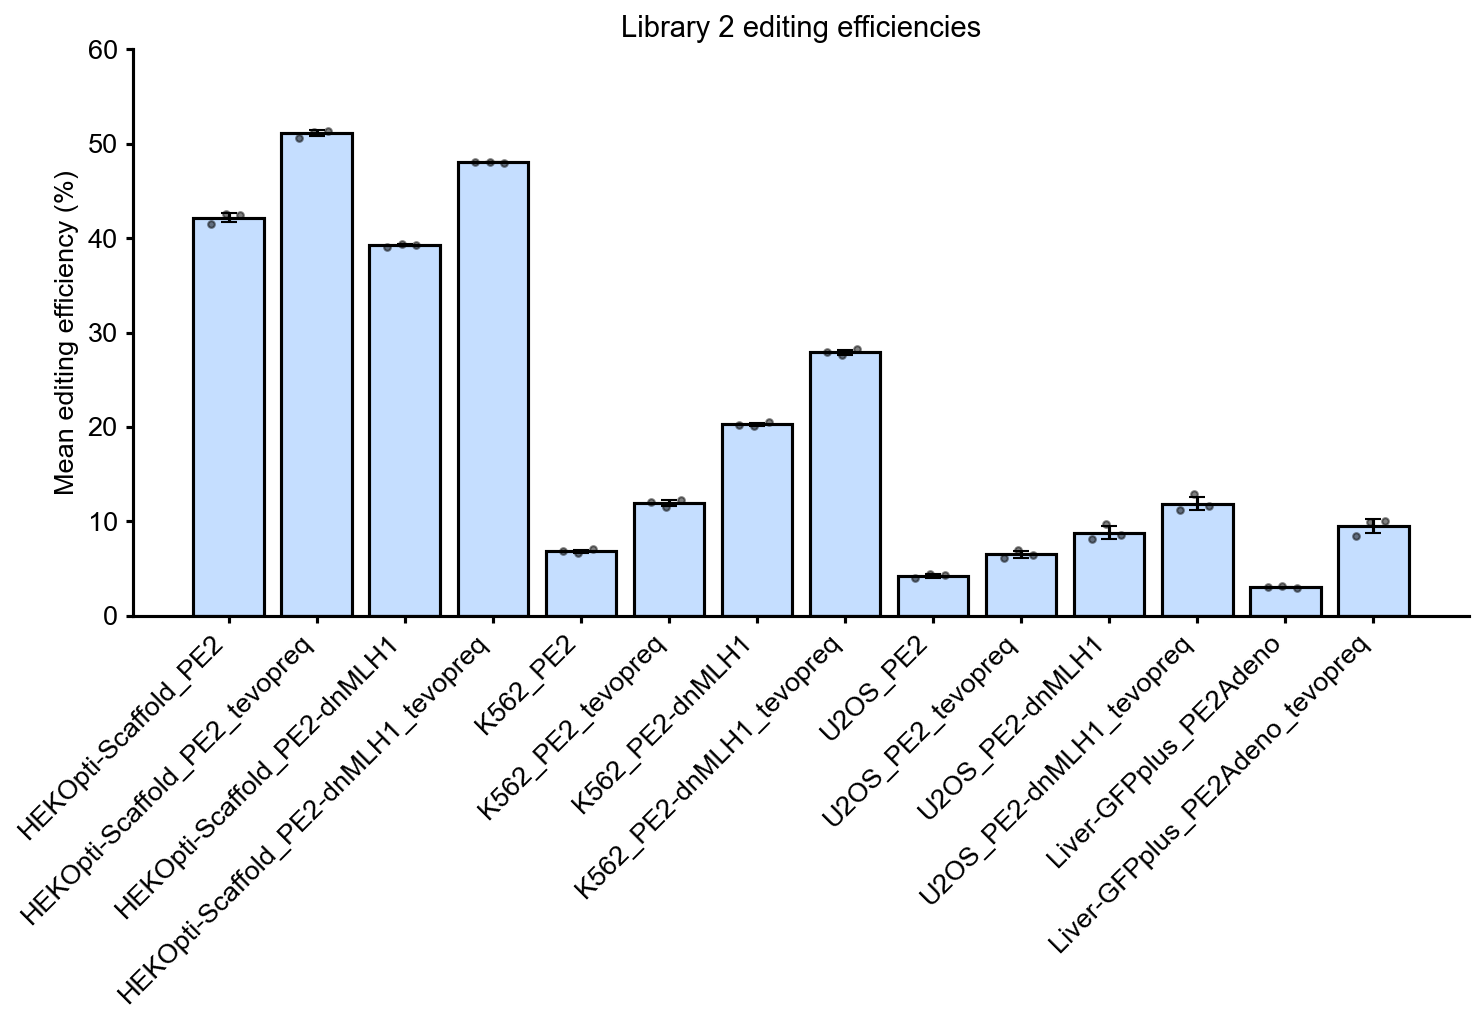

In [56]:
experimentalsetuplist = ['HEKOpti-Scaffold_PE2','HEKOpti-Scaffold_PE2-dnMLH1',
 
 'K562_PE2', 'K562_PE2-dnMLH1','U2OS_PE2', 'U2OS_PE2-dnMLH1',
 'Liver-GFPplus_PE2Adeno']

individualreplist = []
samplenames = []
sampleaverage = []
samplestd = []
samplecount = []
for sample in experimentalsetuplist:
    samplenames.append(sample)
    samplenames.append(sample+'_tevopreq')
    if 'Liver' in sample:
        rep1name = 'Liver-GFPplus_PE2Adeno_R2'
        rep2name = 'Liver-GFPplus_PE2Adeno_R3'
        rep3name = 'Liver-GFPplus_PE2Adeno_R4'
        
    else:
        rep1name = sample+'_R1'
        rep2name = sample+'_R2'
        rep3name = sample+'_R3'
        
    
    for tevopreqoption in [False,True]:
        average1 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep1name+'_percentageedited_corrected_individual'].mean()
        average2 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep2name+'_percentageedited_corrected_individual'].mean()
        average3 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep3name+'_percentageedited_corrected_individual'].mean()
        replicateaveragelist = [average1,average2,average3]
        individualreplist.append(average1)
        individualreplist.append(average2)
        individualreplist.append(average3)

        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep1name+'_percentageedited_corrected_individual']))
        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep2name+'_percentageedited_corrected_individual']))
        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep3name+'_percentageedited_corrected_individual']))
        print()
        average = sum(replicateaveragelist)/len(replicateaveragelist)
        #print(len(replicateaveragelist))
        sampleaverage.append(average)
        stddev = np.std(replicateaveragelist)
        samplestd.append(stddev)
fig1, ax1 = plt.subplots(figsize = (11.5,5),dpi=150,sharex=True)
ax1.set_title('Library 2 editing efficiencies', fontsize=titlesize)
ax1.bar(samplenames,sampleaverage,yerr=samplestd, **bar_kwargs)
x = list(samplenames)
y = individualreplist
counter = 0
for i in range(len(x)):
    for repli in range(3):
        ax1.scatter(i+(repli/3-0.4)/2, y[counter], s=10, color='black',alpha=0.5,zorder=2)
        counter+=1

ax1.set_xticks(range(len(samplenames)))
ax1.set_xticklabels(samplenames, ha="right")
ax1.set_ylabel('Mean editing efficiency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0, 60)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
for x in range(len(sampleaverage)):
    print(samplenames[x],round(sampleaverage[x],2))


figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'mean_editing_efficiencies.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [37]:
print('X-fold increase with tevopreQ1 vs. non-tevopreQ1 library')
for x in range(0,len(sampleaverage),2):
    print(samplenames[x],round(sampleaverage[x+1]/sampleaverage[x],2), 'before:',round(sampleaverage[x],2),'after',round(sampleaverage[x+1],2))

X-fold increase with tevopreQ1 vs. non-tevopreQ1 library
HEKOpti-Scaffold_PE2 1.21 before: 42.18 after 51.11
HEKOpti-Scaffold_PE2-dnMLH1 1.22 before: 39.28 after 48.08
K562_PE2 1.74 before: 6.85 after 11.93
K562_PE2-dnMLH1 1.38 before: 20.29 after 27.93
U2OS_PE2 1.54 before: 4.23 after 6.51
U2OS_PE2-dnMLH1 1.35 before: 8.82 after 11.88
Liver-GFPplus_PE2Adeno 3.12 before: 3.04 after 9.47


In [38]:
print('X-fold increase with MLH1dn vs. no MLH1dn')
lst = [0,1,4,5,8,9]
for x in lst:
    print(samplenames[x],round(sampleaverage[x+2]/sampleaverage[x],2))

X-fold increase with MLH1dn vs. no MLH1dn
HEKOpti-Scaffold_PE2 0.93
HEKOpti-Scaffold_PE2_tevopreq 0.94
K562_PE2 2.96
K562_PE2_tevopreq 2.34
U2OS_PE2 2.08
U2OS_PE2_tevopreq 1.82


916
916
916

922
922
922

917
917
917

924
924
924

879
879
879

869
869
869

877
877
877

866
866
866

K562_Pemax 4.19
K562_Pemax_tevopreq 8.75
K562_Pemax-dnMLH1 14.05
K562_Pemax-dnMLH1_tevopreq 22.22
U2OS_Pemax 2.31
U2OS_Pemax_tevopreq 4.54
U2OS_Pemax-dnMLH1 3.86
U2OS_Pemax-dnMLH1_tevopreq 6.87


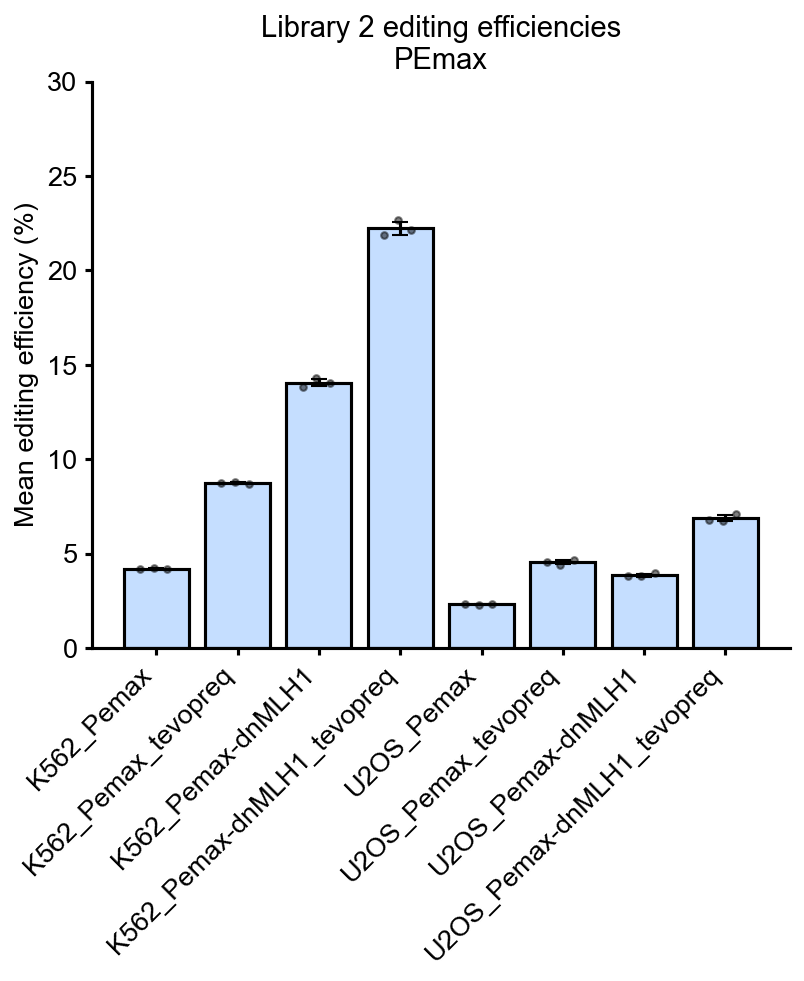

In [39]:
experimentalsetuplist = ['K562_Pemax', 'K562_Pemax-dnMLH1','U2OS_Pemax', 'U2OS_Pemax-dnMLH1']
pemaxlist = experimentalsetuplist.copy()

individualreplist = []
samplenames = []
sampleaverage = []
samplestd = []
for sample in experimentalsetuplist:
    samplenames.append(sample)
    samplenames.append(sample+'_tevopreq')
    if 'Liver' in sample:
        rep1name = 'Liver-GFPplus_PE2Adeno_R2'
        rep2name = 'Liver-GFPplus_PE2Adeno_R3'
        rep3name = 'Liver-GFPplus_PE2Adeno_R4'
        
    else:
        rep1name = sample+'_R1'
        rep2name = sample+'_R2'
        rep3name = sample+'_R3'
        
    
    for tevopreqoption in [False,True]:
        average1 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep1name+'_percentageedited_corrected_individual'].mean()
        average2 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep2name+'_percentageedited_corrected_individual'].mean()
        average3 = experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep3name+'_percentageedited_corrected_individual'].mean()
        replicateaveragelist = [average1,average2,average3]
        individualreplist.append(average1)
        individualreplist.append(average2)
        individualreplist.append(average3)

                
        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep1name+'_percentageedited_corrected_individual']))
        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep2name+'_percentageedited_corrected_individual']))
        print(len(experimentdict[sample][experimentdict[sample]['tevopreq'] == tevopreqoption][rep3name+'_percentageedited_corrected_individual']))
        print()
        average = sum(replicateaveragelist)/len(replicateaveragelist)
        sampleaverage.append(average)
        stddev = np.std(replicateaveragelist)
        samplestd.append(stddev)
fig1, ax1 = plt.subplots(figsize = (6,5),dpi=150,sharex=True)
ax1.set_title('Library 2 editing efficiencies\nPEmax', fontsize=titlesize)
ax1.bar(samplenames,sampleaverage,yerr=samplestd, **bar_kwargs)
x = list(samplenames)
y = individualreplist
counter = 0
for i in range(len(x)):
    for repli in range(3):
        ax1.scatter(i+(repli/3-0.4)/2, y[counter], s=10, color='black',alpha=0.5,zorder=2)
        counter+=1
ax1.set_xticks(range(len(samplenames)))
ax1.set_xticklabels(samplenames, ha="right")
ax1.set_ylabel('Mean editing efficiency (%)', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0, 30)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
for x in range(len(sampleaverage)):
    print(samplenames[x],round(sampleaverage[x],2))


figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PEmax_mean_editing_efficiencies.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [40]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]

experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Liver' in x]

experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
dataframe = dataframe[['K562_PE2_averageedited','K562_PE2-dnMLH1_averageedited',
        'U2OS_PE2_averageedited','U2OS_PE2-dnMLH1_averageedited','K562_Pemax_averageedited','K562_Pemax-dnMLH1_averageedited',
        'U2OS_Pemax_averageedited','U2OS_Pemax-dnMLH1_averageedited']]
dataframe = dataframe.add_suffix('_nontevopreq')


correlations = dataframe.corr('spearman')
correlations_nontevopreq = correlations


sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]

experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Liver' in x]

experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
dataframe = dataframe[['K562_PE2_averageedited','K562_PE2-dnMLH1_averageedited',
        'U2OS_PE2_averageedited','U2OS_PE2-dnMLH1_averageedited','K562_Pemax_averageedited','K562_Pemax-dnMLH1_averageedited',
        'U2OS_Pemax_averageedited','U2OS_Pemax-dnMLH1_averageedited']]
dataframe = dataframe.add_suffix('_tevopreq')

correlations = dataframe.corr('spearman')
correlations_tevopreq = correlations
correlations_combined = pd.concat([correlations_tevopreq,correlations_nontevopreq])

samplenames = correlations_combined.keys()
samplevalues = list(correlations_combined)


In [41]:
pemaxlist = ['K562_Pemax', 'K562_Pemax-dnMLH1','U2OS_Pemax', 'U2OS_Pemax-dnMLH1']
pe2list = ['K562_PE2', 'K562_PE2-dnMLH1','U2OS_PE2', 'U2OS_PE2-dnMLH1']
expcondition = ['K562','K562 + MLH1dn', 'U2OS', 'U2OS + MLH1dn']

namelist = []
correlationlist = []
for index, sample in enumerate(pe2list):
    for tevopreqoption in [False,True]:
        if tevopreqoption == False:
            name = expcondition[index]
            correlation = correlations_combined.at[pe2list[index]+'_averageedited_nontevopreq',pemaxlist[index]+'_averageedited_nontevopreq']
            namelist.append(name)
            correlationlist.append(correlation)
        else:
            name = expcondition[index] + ' + tevopreQ1'
            correlation = correlations_combined.at[pe2list[index]+'_averageedited_tevopreq',pemaxlist[index]+'_averageedited_tevopreq']
            namelist.append(name)
            correlationlist.append(correlation)

In [42]:
correlationlist

[0.91562667708094,
 0.9567616541414181,
 0.9645906966756513,
 0.9618719156814767,
 0.8821831282696628,
 0.924331610217846,
 0.8959111928093774,
 0.9069243896770695]

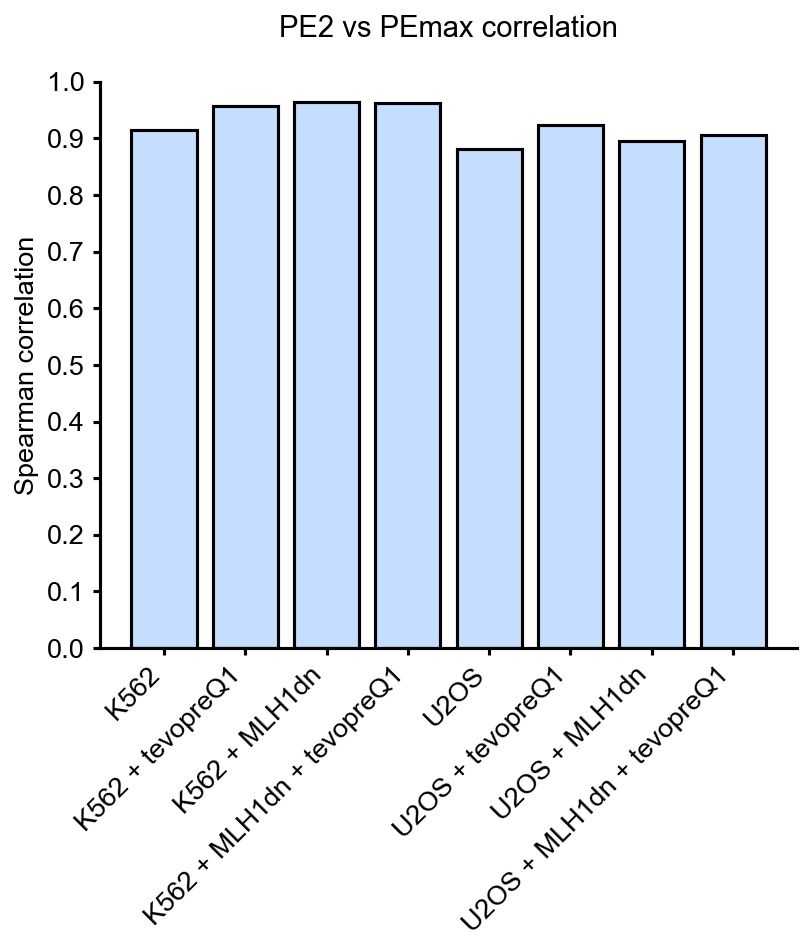

In [43]:
samplenames = namelist
samplevalues = correlationlist

fig1, ax1 = plt.subplots(figsize = (6,5),dpi=150,sharex=True)
ax1.set_title('PE2 vs PEmax correlation\n', fontsize=titlesize)
ax1.bar(samplenames,samplevalues, **bar_kwargs)
ax1.set_xticks(range(len(samplenames)))
ax1.set_xticklabels(samplenames, ha="right")
ax1.set_yticks(np.linspace(0,1,11))
ax1.set_ylabel('Spearman correlation', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PE2vsPEmax_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Comparison PRIDICT score to HEK293T (PE2) subscreen (w/o tevopreq)

(-1.0, 100.0)

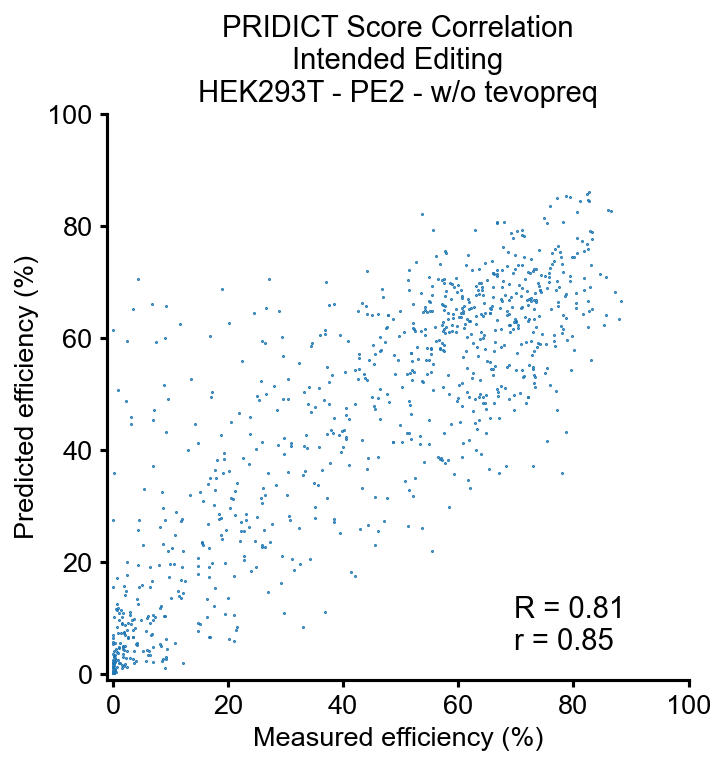

In [92]:
xname = 'HEKOpti-Scaffold_PE2_averageedited'
yname = 'PRIDICT_editing_Score_deep'

dataframe = templatedf_nontevopreq[[xname,yname]].copy()
dataframe = dataframe.dropna()

xvalues = dataframe[xname]
yvalues = dataframe[yname]

R = stats.spearmanr(yvalues,xvalues)[0]
r = stats.pearsonr(yvalues,xvalues)[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(xvalues,yvalues, s=0.2)
ax.set_title('PRIDICT Score Correlation\nIntended Editing\nHEK293T - PE2 - w/o tevopreq', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.7,0.15, 'R = '+str(round(R,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

ax.set_ylim(-1,100)
ax.set_xlim(-1,100)


## Comparison PRIDICT score to HEK293T (PE2) subscreen (WITH tevopreq)

(-1.0, 100.0)

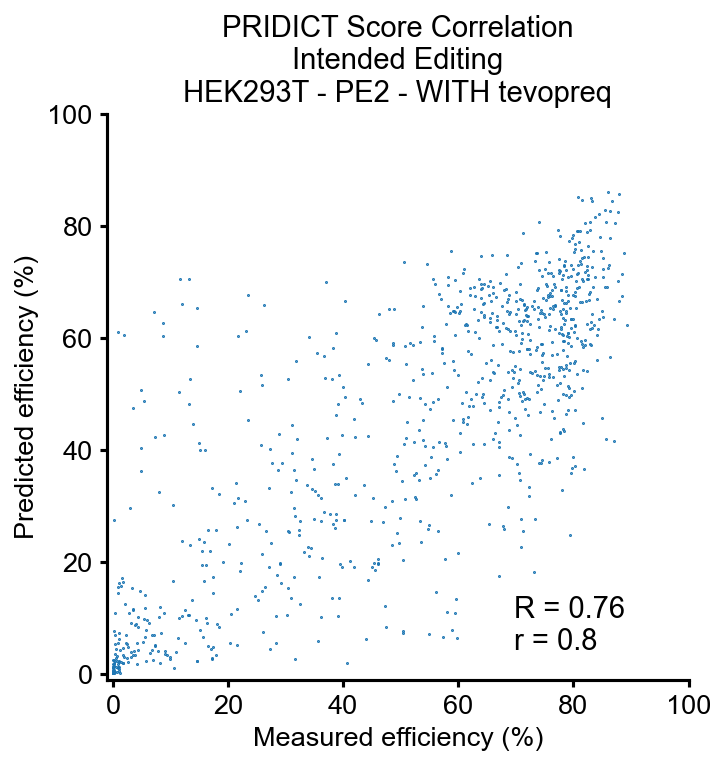

In [93]:
xname = 'HEKOpti-Scaffold_PE2_averageedited'
yname = 'PRIDICT_editing_Score_deep'

dataframe = templatedf_tevopreq[[xname,yname]].copy()
dataframe = dataframe.dropna()

xvalues = dataframe[xname]
yvalues = dataframe[yname]

R = stats.spearmanr(yvalues,xvalues)[0]
r = stats.pearsonr(yvalues,xvalues)[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(xvalues,yvalues, s=0.2)
ax.set_title('PRIDICT Score Correlation\nIntended Editing\nHEK293T - PE2 - WITH tevopreq', fontsize=titlesize)
ax.set_xlabel('Measured efficiency (%)', fontsize=lsize)
ax.set_ylabel('Predicted efficiency (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.7,0.15, 'R = '+str(round(R,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

ax.set_ylim(-1,100)
ax.set_xlim(-1,100)


Index(['HEKOpti-Scaffold_PE2_averageedited', 'K562_PE2_averageedited',
       'U2OS_PE2_averageedited', 'pridict'],
      dtype='object')


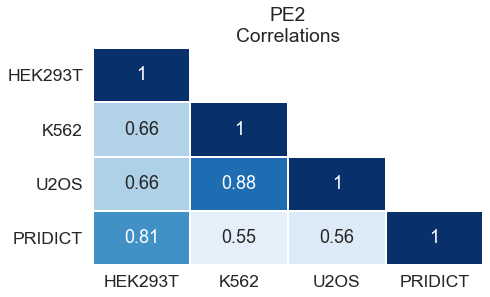

In [101]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = ['HEKOpti-Scaffold_PE2_averageedited', 'K562_PE2_averageedited',
        'U2OS_PE2_averageedited']

dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
print(dataframe.columns)

fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
y_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PE2\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'PE2_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

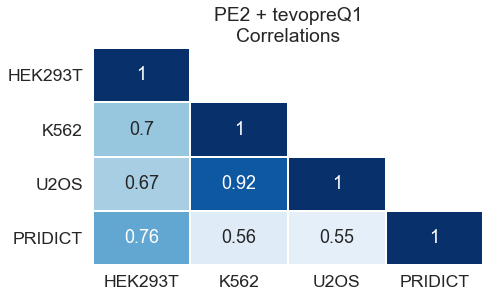

In [100]:
sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = ['HEKOpti-Scaffold_PE2_averageedited', 'K562_PE2_averageedited',
        'U2OS_PE2_averageedited']

dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']

fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
y_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PE2 + tevopreQ1\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0) 
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'PE2_tevopreq_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

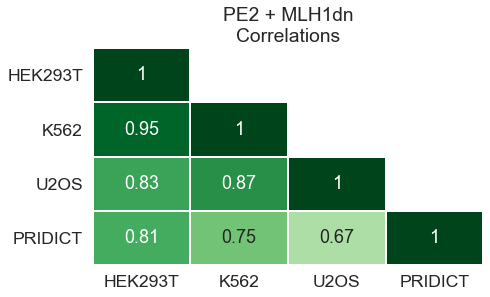

In [102]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]
experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Pemax' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Liver' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if 'dnMLH1' in x]
experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']

fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Greens", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
y_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PE2 + MLH1dn\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0) 
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'PE2_dnMLH1_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

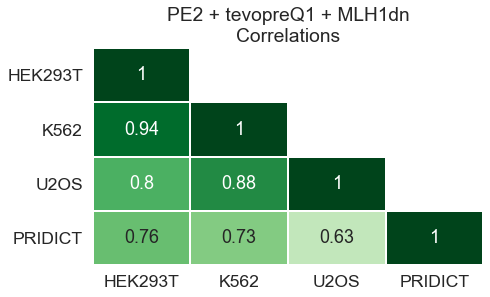

In [103]:
sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]
#experimentlistaverageedited.append('largescreen_averageedited')
experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Pemax' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Liver' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if 'dnMLH1' in x]
experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']

fig_dims = (7,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Greens", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
y_axis_labels = ['HEK293T','K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PE2 + tevopreQ1 + MLH1dn\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0) 
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'PE2_tevopreq_dnMLH1_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

Index(['K562_Pemax_averageedited', 'U2OS_Pemax_averageedited', 'pridict'], dtype='object')


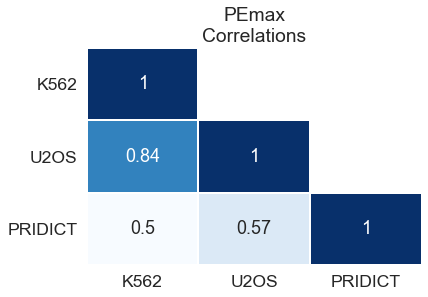

In [104]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = ['K562_Pemax_averageedited',
        'U2OS_Pemax_averageedited']

dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
print(dataframe.columns)

fig_dims = (6,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['K562','U2OS','PRIDICT']
y_axis_labels = ['K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PEmax\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PEmax_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

Index(['K562_Pemax_averageedited', 'U2OS_Pemax_averageedited', 'pridict'], dtype='object')


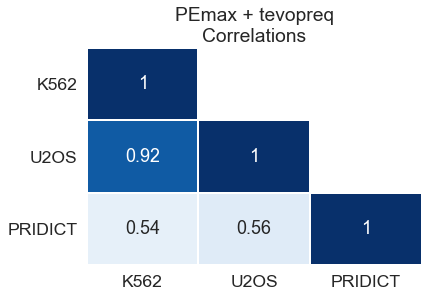

In [105]:
sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = ['K562_Pemax_averageedited',
        'U2OS_Pemax_averageedited']

dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
print(dataframe.columns)

fig_dims = (6,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Blues", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['K562','U2OS','PRIDICT']
y_axis_labels = ['K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PEmax + tevopreq\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PEmax_tevopreq_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

Index(['K562_Pemax-dnMLH1_averageedited', 'U2OS_Pemax-dnMLH1_averageedited',
       'pridict'],
      dtype='object')


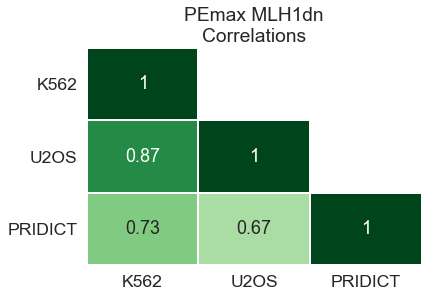

In [106]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]
#experimentlistaverageedited.append('largescreen_averageedited')
experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'PE2' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'HEK' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if 'dnMLH1' in x]
experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']

print(dataframe.columns)

fig_dims = (6,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Greens", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['K562','U2OS','PRIDICT']
y_axis_labels = ['K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PEmax MLH1dn\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PEmax_dnMLH1_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

Index(['K562_Pemax-dnMLH1_averageedited', 'U2OS_Pemax-dnMLH1_averageedited',
       'pridict'],
      dtype='object')


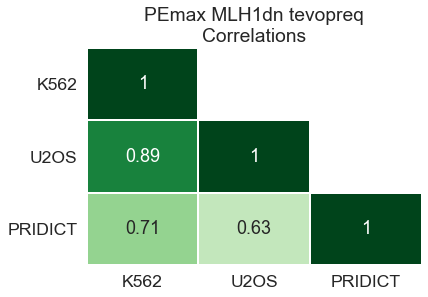

In [107]:
sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]
#experimentlistaverageedited.append('largescreen_averageedited')
experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'PE2' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'HEK' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if 'dnMLH1' in x]
experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']

print(dataframe.columns)

fig_dims = (6,4)
fig, ax = plt.subplots(figsize=fig_dims)
cmap = sn.color_palette("Greens", as_cmap=True)
corr = dataframe.corr('spearman')
x_axis_labels = ['K562','U2OS','PRIDICT']
y_axis_labels = ['K562','U2OS','PRIDICT']
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)
sn.set(font_scale = 1.6)
sn.heatmap(corr, annot = True, fmt='.2g',vmin=0.5, vmax=1,linewidths=1.5,linecolor='white',cbar=False,cmap= cmap,mask=mask,annot_kws={"size":18},xticklabels=x_axis_labels, yticklabels=y_axis_labels).set(title='PEmax MLH1dn tevopreq\nCorrelations')
ax.tick_params(left=False, bottom=False)
ax.set_facecolor("white")
plt.yticks(rotation=0)

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\Sup9_Subscreen\\'
plt.savefig(figurepath+'PEmax_dnMLH1_tevopreq_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [44]:
sourcedf = templatedf_nontevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]
#experimentlistaverageedited.append('largescreen_averageedited')
experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Pemax' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'dnMLH1' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'unsorted' in x]
experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
dataframe = dataframe[['pridict', 'HEKOpti-Scaffold_PE2_averageedited','K562_PE2_averageedited',
        'Liver-GFPplus_PE2Adeno_averageedited',
        'U2OS_PE2_averageedited']]
dataframe = dataframe.add_suffix('_nontevopreq')

livercorrelations = dataframe.corr('spearman')['Liver-GFPplus_PE2Adeno_averageedited_nontevopreq']
livercorrelations_nontevopreq = livercorrelations.drop(labels=['Liver-GFPplus_PE2Adeno_averageedited_nontevopreq'])

sourcedf = templatedf_tevopreq

experimentlist = sampledf[(sampledf['Editor'] != 'Control')]['Cell_line_Editor'].unique()
experimentlistaverageedited = [x+'_averageedited' for x in experimentlist]

experimentlistaverageedited.remove('HEKWT-Scaffold_PE2_averageedited')
experimentlistaverageedited = sorted(experimentlistaverageedited)
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'Pemax' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'dnMLH1' in x]
experimentlistaverageedited = [x for x in experimentlistaverageedited if not 'unsorted' in x]

experimentlistaverageedited
dataframe = sourcedf[experimentlistaverageedited].copy()
dataframe['pridict'] = sourcedf['PRIDICT_editing_Score_deep']
dataframe = dataframe[['pridict', 'HEKOpti-Scaffold_PE2_averageedited','K562_PE2_averageedited',
        'Liver-GFPplus_PE2Adeno_averageedited',
        'U2OS_PE2_averageedited']]
dataframe = dataframe.add_suffix('_tevopreq')

livercorrelations = dataframe.corr('spearman')['Liver-GFPplus_PE2Adeno_averageedited_tevopreq']
livercorrelations_tevopreq = livercorrelations.drop(labels=['Liver-GFPplus_PE2Adeno_averageedited_tevopreq'])
livercorrelations_combined = pd.concat([livercorrelations_tevopreq,livercorrelations_nontevopreq])
livercorrelations_combined = livercorrelations_combined.reindex(['pridict_nontevopreq','pridict_tevopreq','HEKOpti-Scaffold_PE2_averageedited_nontevopreq',
 'HEKOpti-Scaffold_PE2_averageedited_tevopreq','K562_PE2_averageedited_nontevopreq',
 'K562_PE2_averageedited_tevopreq','U2OS_PE2_averageedited_nontevopreq','U2OS_PE2_averageedited_tevopreq'])
samplenames = livercorrelations_combined.keys()
samplevalues = list(livercorrelations_combined)
samplevalues

[0.42738428343914175,
 0.47842170011119156,
 0.5002533848817737,
 0.5472537024527447,
 0.6589565431319097,
 0.7992233669924623,
 0.6451353003667499,
 0.7866010552955649]

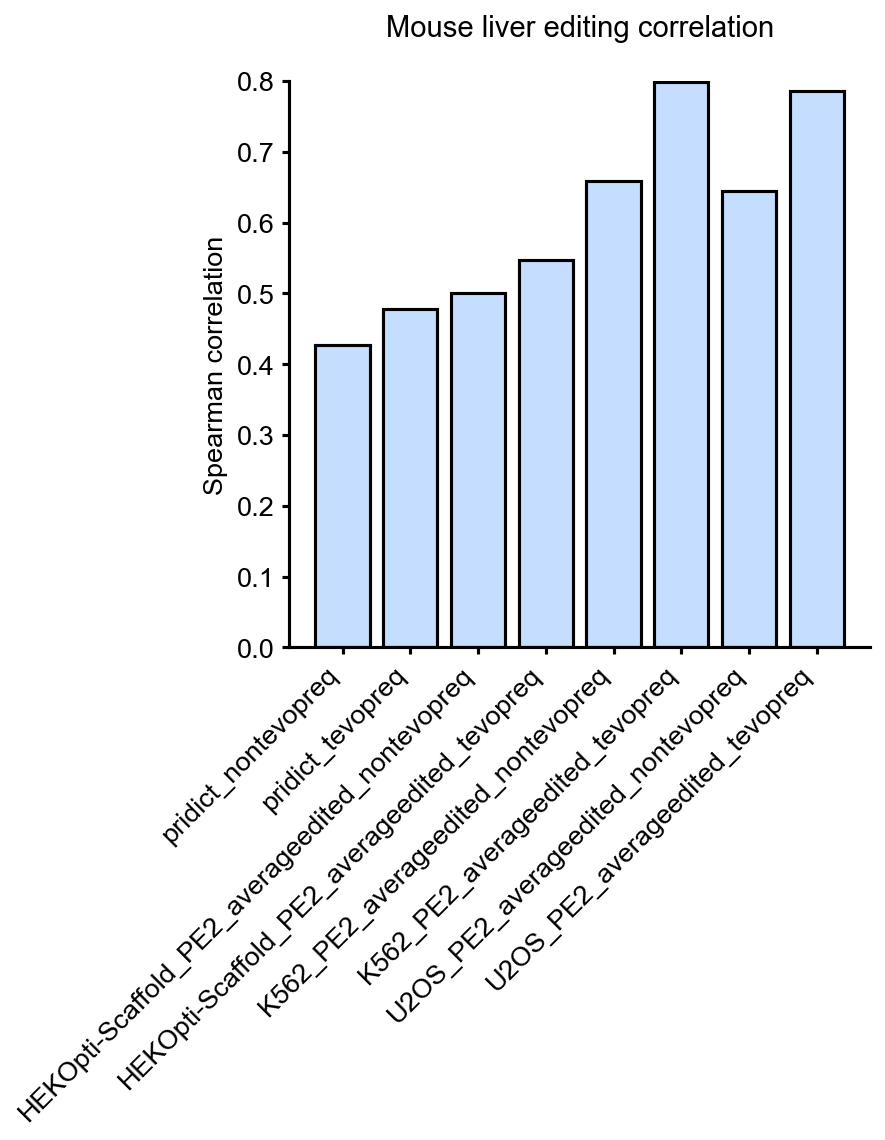

In [45]:

fig1, ax1 = plt.subplots(figsize = (5,5),dpi=150,sharex=True)
ax1.set_title('Mouse liver editing correlation\n', fontsize=titlesize)
ax1.bar(samplenames,samplevalues, **bar_kwargs)
ax1.set_xticks(range(len(samplenames)))
ax1.set_xticklabels(samplenames, ha="right")
ax1.set_ylabel('Spearman correlation', fontsize=lsize)
ax1.tick_params(axis='x', labelsize= lsize, width=1.5, rotation=45)
ax1.tick_params(axis='y', labelsize= lsize, width=1.5)
ax1.set_ylim(0, 0.8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'Mouse_liver_correlations.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

In [46]:
truescore = 'Liver-GFPplus_PE2Adeno_averageedited'
predscore = 'PRIDICT_editing_Score_deep'
cutoff = 70

liversorteddf = templatedf_nontevopreq[[truescore,predscore]].copy()
preddfhigh = liversorteddf[liversorteddf[predscore] > cutoff]
preddflow = liversorteddf[liversorteddf[predscore] < cutoff]

preddfhigh = preddfhigh.dropna()
preddflow = preddflow.dropna()
highloweditdata= [preddflow[truescore], preddfhigh[truescore]]
highlowxticks= ['<'+str(cutoff)+'\nPRIDICT', '>'+str(cutoff)+'\nPRIDICT' ]
mannwithneyu_test = stats.mannwhitneyu(preddfhigh[truescore], preddflow[truescore])
print(mannwithneyu_test[1])
print('pegRNAs with high score:',len(preddfhigh))
print('median highscore pegRNAs:',preddfhigh[truescore].median())
print('pegRNAs with low score:',len(preddflow))
print('median lowscore pegRNAs:',preddflow[truescore].median())


liversorteddf = templatedf_tevopreq[[truescore,predscore]].copy()
preddfhigh = liversorteddf[liversorteddf[predscore] > cutoff]
preddflow = liversorteddf[liversorteddf[predscore] < cutoff]

preddfhigh = preddfhigh.dropna()
preddflow = preddflow.dropna()

print('pegRNAs with high score:',len(preddfhigh))
print('median highscore pegRNAs:',preddfhigh[truescore].median())
print('pegRNAs with low score:',len(preddflow))
print('median lowscore pegRNAs:',preddflow[truescore].median())
highloweditdata.append(preddflow[truescore])
highloweditdata.append(preddfhigh[truescore])
highlowxticks.append('<'+str(cutoff)+'\nPRIDICT')
highlowxticks.append('>'+str(cutoff)+'\nPRIDICT')
mannwithneyu_test = stats.mannwhitneyu(preddfhigh[truescore], preddflow[truescore])
print(mannwithneyu_test[1])



3.740526625402067e-11
pegRNAs with high score: 98
median highscore pegRNAs: 3.8353098995735557
pegRNAs with low score: 771
median lowscore pegRNAs: 0.4016233701002552
pegRNAs with high score: 108
median highscore pegRNAs: 13.583318779901115
pegRNAs with low score: 803
median lowscore pegRNAs: 2.326054828246911
2.695679556690256e-13


pegRNAs with high score: 108
median highscore pegRNAs: 13.583318779901115
pegRNAs with low score: 803
median lowscore pegRNAs: 2.326054828246911


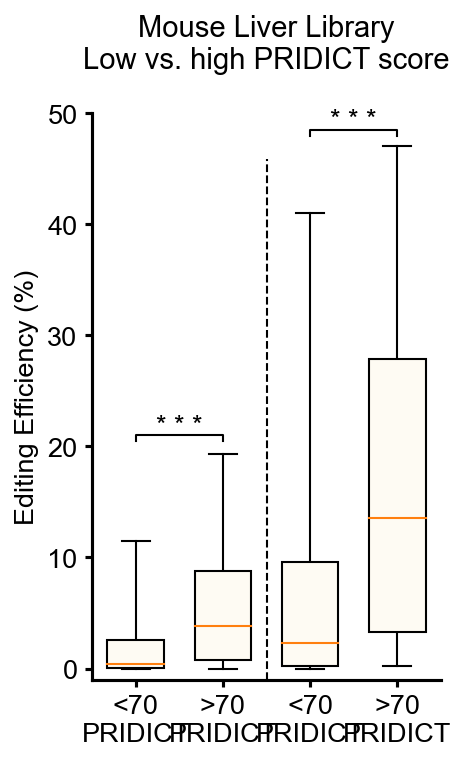

In [47]:
fig2, ax3 = plt.subplots(figsize=(3,5), dpi=150)
ax3.set_title('Mouse Liver Library\nLow vs. high PRIDICT score\n', fontsize=titlesize)
ax3.boxplot(highloweditdata, **boxplot_kwargs, showfliers=False)
ax3.set_xticklabels(highlowxticks)
ax3.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
ax3.tick_params(axis='x', labelsize= lsize, width=1.5)
ax3.tick_params(axis='y', labelsize= lsize, width=1.5)
ax3.set_ylim(-1, 50)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(left=True, bottom=True)
ax3.axvline(2.5,0,0.92,color='black',linestyle='dashed', linewidth=1)
### add significance stars to plot ###
x1, x2 = 1,2   # between which boxes should the line be?
y1,y2 = 20.5,21
plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
plt.text((x1+x2)*.5, y1 +0.3, "* * *", ha='center', va='bottom',fontsize=lsize)

x1, x2 = 3,4   # between which boxes should the line be?
y1,y2 = 48,48.5
plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
plt.text((x1+x2)*.5, y1 +0.3, "* * *", ha='center', va='bottom',fontsize=lsize)

print('pegRNAs with high score:',len(preddfhigh))
print('median highscore pegRNAs:',preddfhigh[truescore].median())
print('pegRNAs with low score:',len(preddflow))
print('median lowscore pegRNAs:',preddflow[truescore].median())

figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'Liver_HighLow_PRIDICTScore_cutoff'+str(cutoff)+'.pdf', format='pdf',
        transparent=True,bbox_inches='tight')

## Analyse effect of tevopreq on different edits

In [48]:
from collections import Counter

cell_line = 'K562'
topxnumber = 100

#dataframetevopreq = templatedf_tevopreq.copy()
dataframe = templatedf.copy()
dataframe = dataframe.set_index('uniqueindex_subscreen')
for index, row in dataframe.iterrows():
    if row.tevopreq == False:
        tevopreqequivalent = row.tevopreqequivalent_uniqueindex_subscreen
        try:
            dataframe.at[index,cell_line+'_PE2_tevopreq_averageedited'] = dataframe.at[int(row.tevopreqequivalent_uniqueindex_subscreen),cell_line+'_PE2_averageedited']
        except:
            continue

#dataframe = dataframe[(dataframe['Correction_Type'] == 'Replacement') & (dataframe.Correction_Length == 1)]
dataframe = dataframe[['PBSlength','PBS_GC_content','PBSmt','Extension_GC_content','RToverhanglength','RTlength',cell_line+'_PE2_tevopreq_averageedited',cell_line+'_PE2_averageedited']].dropna()
dataframe[cell_line+'_PE2_tevopreq_increase_in_editing'] = dataframe[cell_line+'_PE2_tevopreq_averageedited'] - dataframe[cell_line+'_PE2_averageedited']

(-1.0, 100.0)

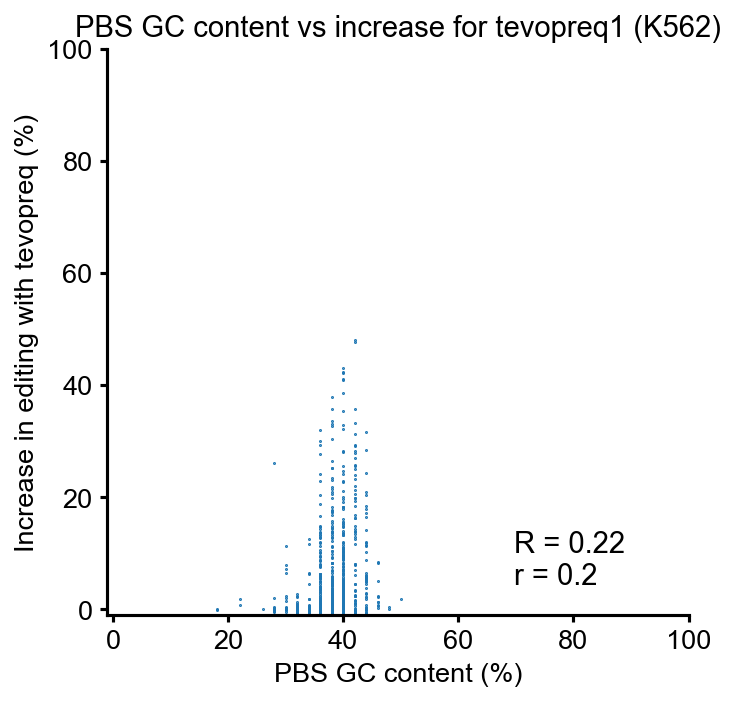

In [49]:
xname = 'PBSmt'
yname = 'K562_PE2_tevopreq_increase_in_editing'

xvalues = dataframe[xname]
yvalues = dataframe[yname]

R = stats.spearmanr(yvalues,xvalues)[0]
r = stats.pearsonr(yvalues,xvalues)[0]

fig, ax = plt.subplots(1,1,figsize = (5,5),dpi=150)
plt.rcParams['axes.linewidth'] = 1.5
ax.scatter(xvalues,yvalues, s=0.2)
ax.set_title('PBS GC content vs increase for tevopreq1 (K562)', fontsize=titlesize)
ax.set_xlabel('PBS GC content (%)', fontsize=lsize)
ax.set_ylabel('Increase in editing with tevopreq (%)', fontsize=lsize)
ax.tick_params(axis='x', labelsize= lsize, width=1.5)
ax.tick_params(axis='y', labelsize= lsize, width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.7,0.15, 'R = '+str(round(R,2))+'\nr = '+str(round(r,2)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

ax.set_ylim(-1,100)
ax.set_xlim(-1,100)


In [50]:
templatedf_tevopreq
conditionlist = ['HEKOpti-Scaffold_PE2_averageedited',
 'HEKOpti-Scaffold_PE2-dnMLH1_averageedited',
 'U2OS_PE2_averageedited',
 'U2OS_PE2-dnMLH1_averageedited',
 'K562_PE2_averageedited',
 'K562_PE2-dnMLH1_averageedited',
 'Liver-GFPplus_PE2Adeno_averageedited']


ratiolist = []
meanlist = []
for condition in conditionlist:
    afterA = templatedf_tevopreq[templatedf_tevopreq['baseafter'] == 'A'][condition].mean()
    nonA = templatedf_tevopreq[templatedf_tevopreq['baseafter'] != 'A'][condition].mean()
    
    ratio = afterA/nonA
    ratiolist.append(ratio)
    meanlist.append(afterA)
    meanlist.append(nonA)

In [51]:
ratiolist

[1.0995893270950154,
 1.1179103114914821,
 3.073064601371736,
 1.9173972773782892,
 3.1568801709498904,
 1.308246823060274,
 2.5463518062486026]

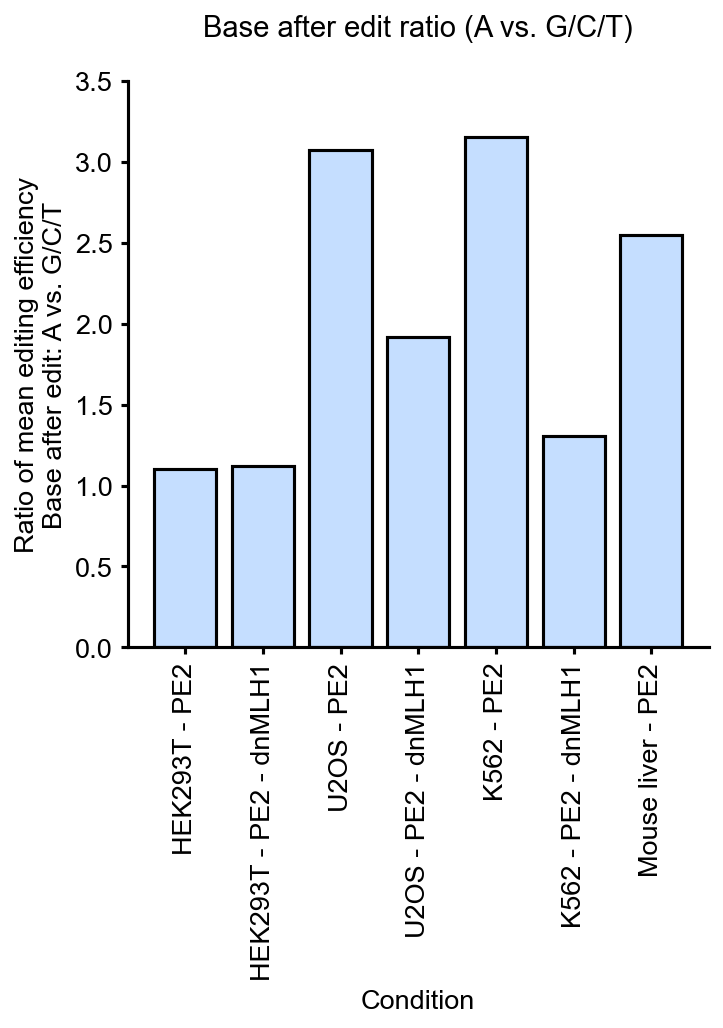

In [53]:
labels = ['HEK293T - PE2','HEK293T - PE2 - dnMLH1','U2OS - PE2','U2OS - PE2 - dnMLH1','K562 - PE2','K562 - PE2 - dnMLH1','Mouse liver - PE2']

fig30, ax30 = plt.subplots(figsize=(5,5), dpi=150)
ax30.set_title('Base after edit ratio (A vs. G/C/T)\n', fontsize=titlesize)
ax30.bar(labels,ratiolist, **bar_kwargs)
#ax30.set_xticklabels(labels)
ax30.set_xlabel("Condition", fontsize=lsize)
ax30.tick_params(axis='x', labelsize= lsize, width=1.5)
ax30.tick_params(axis='y', labelsize= lsize, width=1.5)
ax30.set_ylim(0,3.5)
ax30.spines['right'].set_visible(False)
ax30.spines['top'].set_visible(False)
plt.xticks(rotation='vertical')
ax30.set_ylabel('Ratio of mean editing efficiency\nBase after edit: A vs. G/C/T', fontsize=lsize)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'baseaftereditratio.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()

In [54]:
templatedf_tevopreq
conditionlist = ['HEKOpti-Scaffold_PE2_averageedited',
 'HEKOpti-Scaffold_PE2-dnMLH1_averageedited',
 'U2OS_PE2_averageedited',
 'U2OS_PE2-dnMLH1_averageedited',
 'K562_PE2_averageedited',
 'K562_PE2-dnMLH1_averageedited',
 'Liver-GFPplus_PE2Adeno_averageedited']


editedGCratiolist = []
editedGCmeanlist = []
for condition in conditionlist:
    editedGC = templatedf_tevopreq[(templatedf_tevopreq['ReferenceAllele'] == 'G') | (templatedf_tevopreq['ReferenceAllele'] == 'C')][condition].mean()
    nonGC = templatedf_tevopreq[(templatedf_tevopreq['ReferenceAllele'] == 'A') | (templatedf_tevopreq['ReferenceAllele'] == 'T')][condition].mean()
    
    ratio = editedGC/nonGC
    editedGCratiolist.append(ratio)
    editedGCmeanlist.append(editedGC)
    editedGCmeanlist.append(nonGC)

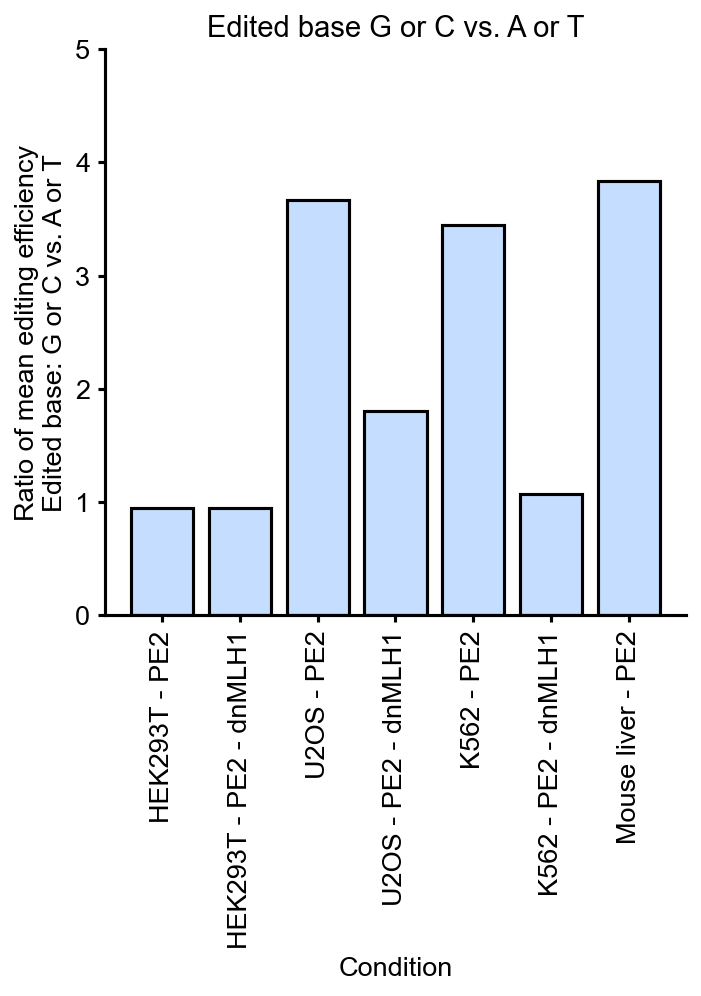

In [55]:
labels = ['HEK293T - PE2','HEK293T - PE2 - dnMLH1','U2OS - PE2','U2OS - PE2 - dnMLH1','K562 - PE2','K562 - PE2 - dnMLH1','Mouse liver - PE2']

fig30, ax30 = plt.subplots(figsize=(5,5), dpi=150)
ax30.set_title('Edited base G or C vs. A or T', fontsize=titlesize)
ax30.bar(labels,editedGCratiolist, **bar_kwargs)
#ax30.set_xticklabels(labels)
ax30.set_xlabel("Condition", fontsize=lsize)
ax30.tick_params(axis='x', labelsize= lsize, width=1.5)
ax30.tick_params(axis='y', labelsize= lsize, width=1.5)
ax30.set_ylim(0,5)
ax30.spines['right'].set_visible(False)
ax30.spines['top'].set_visible(False)
plt.xticks(rotation='vertical')
ax30.set_ylabel('Ratio of mean editing efficiency\nEdited base: G or C vs. A or T', fontsize=lsize)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\05_Subscreen\\'
plt.savefig(figurepath+'editedGCvsATratio.pdf', format='pdf',
        transparent=True,bbox_inches='tight')
plt.show()